# 09: Make plots (main)

In this script, we create all plots for the main article.

In [1]:
import mpltern
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap

In [2]:
%run common_definitions.py
%run plotting_functions.py

In [3]:
output_fp = "../output/" + BW_PROJECTNAME

In [4]:
import os

if not os.path.exists(output_fp+"/plots"):
    os.mkdir(output_fp+"/plots")

if not os.path.exists(output_fp+"/plots/main"):
    os.mkdir(output_fp+"/plots/main")

### Load data

In [5]:
costs_regional_averages = pd.read_csv(output_fp+"/costs_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average", "perspective"]
)

In [6]:
direct_costs_regional_averages = pd.read_csv(output_fp+"/direct_costs_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average", "perspective"]
)

In [7]:
indirect_costs_regional_averages = pd.read_csv(output_fp+"/indirect_costs_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average", "perspective"]
)

In [8]:
all_perspectives = list(costs_regional_averages.index.unique(level="perspective"))
all_sectors = list(costs_regional_averages.index.unique(level="sector"))
all_techs = list(costs_regional_averages.index.unique(level="short name"))

In [9]:
plottingnames = pd.read_csv("../mappings/plotting-names.csv").set_index(["short name"])

missing_techs = [tech for tech in all_techs if tech not in plottingnames.index]

plottingnames2 = pd.DataFrame(
    {
        "plotting name (title)": missing_techs,
        "plotting name (tick)": missing_techs,
    },
    index=missing_techs
)

plottingnames = pd.concat((plottingnames, plottingnames2), axis=0)

tech2title = dict(zip(list(plottingnames.index), list(plottingnames["plotting name (title)"])))
tech2tick = dict(zip(list(plottingnames.index), list(plottingnames["plotting name (tick)"])))

### Comparing to production costs

First load the production cost sample. We exclude some costs.

In [10]:
excludes_names = ["bioethanol, willow"]

df_production_costs = pd.read_csv("../data/production_costs_monte_carlo_sample_euro_{}.csv".format(EURO_REF_YEAR))
df_production_costs = df_production_costs[~df_production_costs["short name"].isin(excludes_names)].set_index(
    ["short name", "sector", "sample index"]
)

Then the impacts and MVC sample:

In [11]:
impacts_regional_averages = pd.read_csv(output_fp+"/impacts_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average"]
)
mfs_mc_sample_cc = xr.open_dataarray("../data/mfs_monte_carlo_sample_extended_euro{}.nc".format(str(EURO_REF_YEAR)))

In [12]:
def get_all_total_costs(impact_df, mfs, contract_dim):
    total_costs = xr.DataArray(
        np.tensordot(impact_df[list(mfs.coords["LCIA method"].values)].to_numpy(),
                    mfs.to_numpy(),
                    axes=([1,], [contract_dim,])),
        coords={
            "tech index": list(range(len(impact_df))),
            "impact category": list(mfs.coords["impact category"].values),
            "sample index": list(range(mfs.shape[1]))
        }
    ).sel({"impact category": list(colors_splitCC.keys())}).sum(dim="impact category")

    return pd.DataFrame(
        total_costs.to_numpy(),
        index=impact_df.index,
        columns=list(range(total_costs.shape[1]))
    )

In [13]:
scenario = "SSP2-NPi"
year = 2020
sel = impacts_regional_averages.loc[pd.IndexSlice[:, :, scenario, year, :]]

total_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2)

In [14]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



In [15]:
sectors_available = list(df_production_costs.index.unique(level="sector"))
sort_order = list(sector2color.keys())
selected_sectors = [s for s in sort_order if s in sectors_available]
print(selected_sectors)

['electricity production', 'district or industrial heat', 'residential heating', 'liquids', 'hydrogen and gases']


In [16]:
eec_literature = pd.read_csv("../data/external_costs_literature_EUR{}.csv".format(EURO_REF_YEAR))

In [17]:
study_selection = ["NEEDS", "Sovacool et al"]
eec_literature = eec_literature[eec_literature["source name"].isin(study_selection)].set_index(["source name", "short name"])
eec_literature

index unit  \
source name    short name                                                   
Sovacool et al hard coal power plant                               0   MJ   
               natural gas power plant                             1   MJ   
               hard coal power plant                               2   MJ   
               hard coal power plant                               3   MJ   
               hard coal power plant                               4   MJ   
...                                                              ...  ...   
NEEDS          lignite w CCS (oxy)              abatement costs high   MJ   
               lignite w CCS (post)             abatement costs high   MJ   
               nuclear, pressure water reactor  abatement costs high   MJ   
               wind, offshore                   abatement costs high   MJ   
               wood CHP modern                  abatement costs high   MJ   

                                               currency  year      cost  
source name    short name                                                
Sovacool et al hard coal power plant               euro  2022  0.046317  
               natural gas power plant             euro  2022  0.007150  
               hard coal power plant               euro  2022  0.017184  
               hard coal power plant               euro  2022  0.026911  
               hard coal power plant               euro  2022  0.038329  
...                                                 ...   ...       ...  
NEEDS          lignite w CCS (oxy)                 euro  2022  0.002902  
               lignite w CCS (post)                euro  2022  0.007723  
               nuclear, pressure water reactor     euro  2022  0.000329  
               wind, offshore                      euro  2022  0.000128  
               wood CHP modern                     euro  2022  0.013441  

[326 rows x 5 columns]

Choose more values to compare to samples of production costs.

In [18]:
dflist = []
for idx in eec_literature.index.unique():
    sel = eec_literature.loc[idx]
    df = pd.DataFrame(
        {"cost": np.random.choice(sel["cost"], MC_SAMPLE_SIZE)}
    )
    df["source name"] = idx[0]
    df["short name"] = idx[1]
    df["sample index"] = np.arange(MC_SAMPLE_SIZE)
    dflist.append(df)

literature_costs_resampled = pd.concat(dflist, ignore_index=True)

C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\1042187207.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sel = eec_literature.loc[idx]
C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\1042187207.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sel = eec_literature.loc[idx]
C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\1042187207.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sel = eec_literature.loc[idx]
C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\1042187207.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sel = eec_literature.loc[idx]
C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\1042187207.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  sel = eec_literature.loc[idx]
C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\1042187207.py:3: PerformanceWarning: indexing past lexsort depth may impact perform

In [19]:
prod_costs = df_production_costs.loc[pd.IndexSlice[:, "electricity production", :]]
prod_costs


,,cost
short name,sample index,
BIGCC,0,0.011481
"CSP, tower",0,0.022453
NGCC,0,0.015465
PV commercial,0,0.016020
PV residential,0,0.031654
...,...,...
"hydro, reservoir, non-alpine region",1999,0.013499
"nuclear, pressure water reactor",1999,0.032822
"wind, offshore",1999,0.022326


In [20]:
dflist = []
for name in study_selection:
    a = literature_costs_resampled[literature_costs_resampled["source name"] == name].set_index(["short name", "sample index"])
    b = prod_costs

    idx = a.index.intersection(b.index)

    df = pd.DataFrame(
        {
            "ratio": (a.loc[idx]["cost"] / b.loc[idx]["cost"]).to_numpy()
        },
        index=a.loc[idx].index
    )
    df["source name"] = name
    dflist.append(df.reset_index())

literature_ratios = pd.concat(dflist, ignore_index=True)
literature_ratios.replace("Sovacool et al", "Sovacool", inplace=True)
literature_ratios["technology"] = literature_ratios["short name"].map(tech2tick)
    

    

In [21]:
def production_cost_comparison_two_columns(region, scenario, year, add_other_studies=False, print_ratios=True):
    heights = []
    for sector in selected_sectors:
        sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]
        external_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2).melt(
            var_name="sample index", value_name="cost", ignore_index=False
        ).reset_index().set_index(["short name", "sample index"]
        )

        prod_costs = df_production_costs.loc[pd.IndexSlice[:, sector, :]]

        idx = prod_costs.index.intersection(external_costs.index)
        ratios = external_costs.loc[idx].div(prod_costs.loc[idx]).reset_index()

        heights.append(0.5 + 0.5*len(ratios["short name"].unique()))

    fig = plt.figure(figsize=(10, 10), constrained_layout=True)

    subfigs = fig.subfigures(1, 2)

    axs_left = subfigs[0].subplots(3, 1, sharex=True, height_ratios=heights[:3])
    axs_right = subfigs[1].subplots(2, 1, sharex=True, height_ratios=heights[3:])

    all_axes = list(axs_left) + list(axs_right)

    for ax, sector in zip(all_axes, selected_sectors):
        ax.set_title(sector2plotname[sector])
        sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]
        external_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2).melt(
            var_name="sample index", value_name="cost", ignore_index=False
        ).reset_index().set_index(["short name", "sample index"]
        )

        prod_costs = df_production_costs.loc[pd.IndexSlice[:, sector, :]]

        idx = prod_costs.index.intersection(external_costs.index)
        ratios = external_costs.loc[idx].div(prod_costs.loc[idx]).reset_index()
        ratios["technology"] = ratios["short name"].map(tech2tick)
        ratios.drop(columns="short name", inplace=True)

        if print_ratios:
            print(ratios.groupby("technology").describe()["cost"])

        medians = ratios.groupby("technology").median().reset_index().sort_values("cost", ascending=False)

        sns.violinplot(data=ratios, y="technology", x="cost", log_scale=True,
                      ax=ax, order=medians["technology"], color=sector2color[sector])
        ax.axvline(x=1, ls="dashed", color="gray", zorder=0)

        if sector == "electricity production":
            if add_other_studies:
                sns.boxplot(literature_ratios, hue="source name", y="technology", x="ratio", 
                            legend=True, ax=ax, palette=sns.color_palette(study2color.values()),
                            fliersize=0, whis=(10, 90))
                ax.legend(loc="upper left", fontsize=8)
                left, right = ax.get_xlim()
                ax.set_xlim(0.001, right)

        ax.set_xlabel("")
        ax.set_ylabel("")


    fig.supxlabel("External costs / production costs")

    fig.savefig(output_fp+"/plots/main/01_compare_to_production_two_cols_{}_{}_{}.pdf".format(scenario, year, region))
    plt.close()
        

    # for sector, ax in zip(selected_sectors, axs.flat):
    #     sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]
    #     external_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2).reset_index().melt(
    #         id_vars="short name", var_name="sample index", value_name="cost"
    #     ).reset_index()
    #     external_costs["type"] = "external"

    #     production_costs = df_production_costs[df_production_costs["sector"] == sector]
    #     production_costs["type"] = "production"

    #     techs = set(external_costs["short name"].unique()).intersection(production_costs["short name"].unique())

    #     external_costs = external_costs[external_costs["short name"].isin(techs)].set_index("short name")[["cost", "type"]]
    #     production_costs = production_costs[production_costs["short name"].isin(techs)].set_index("short name")[["cost", "type"]]

    #     plot_data = pd.concat([external_costs, production_costs], axis=0).loc[tech_selection2[sector]].reset_index()

    #     ax.set_title(sector)
    #     sns.boxplot(plot_data, x="short name", y="cost", hue="type", whis=(5, 95), fliersize=0, ax=ax)
    #     ax.set_yscale("log")
    #     ax.set_xlabel("")
    #     ax.set_ylabel("")
    #     ax.tick_params(axis='x', labelrotation=90)

    # fig.supxlabel("Technology")
    # fig.supylabel("Cost in EUR{}/MJ".format(EURO_REF_YEAR))

    # fig.savefig(output_fp+"/plots/SI/compare_to_production_{}_{}_{}.pdf".format(scenario, year, region))
    # plt.close()

In [22]:
production_cost_comparison_two_columns("overall", "SSP2-NPi", 2020, add_other_studies=True)

                   count      mean       std       min       25%       50%  \
technology                                                                   
CSP               2000.0  0.576747  0.840980  0.048478  0.150960  0.199137   
NG CC             2000.0  2.038593  1.467928  0.287294  1.159790  1.653060   
PV commercial     2000.0  2.236414  3.974337  0.132347  0.417893  0.721436   
PV residential    2000.0  1.681321  3.227563  0.033098  0.208115  0.371794   
bio IGCC          2000.0  2.129451  2.769875  0.256218  0.703390  1.120277   
hard coal PP      2000.0  5.812954  4.326709  1.093040  3.046942  4.288495   
hydro, reservoir  2000.0  3.014731  4.421809  0.060938  0.395834  1.255604   
nuclear PP        2000.0  0.379273  0.283081  0.031036  0.141752  0.333437   
wind, offshore    6000.0  1.602643  3.847667  0.028530  0.216803  0.442934   
wood CHP          2000.0  3.538952  2.683462  0.595800  1.843806  2.661778   

                       75%        max  
technology             

In [23]:
def production_cost_comparison_three_columns(region, scenario, year, add_other_studies=False, print_ratios=True):
    heights = []
    for sector in selected_sectors:
        sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]
        external_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2).melt(
            var_name="sample index", value_name="cost", ignore_index=False
        ).reset_index().set_index(["short name", "sample index"]
        )

        prod_costs = df_production_costs.loc[pd.IndexSlice[:, sector, :]]

        idx = prod_costs.index.intersection(external_costs.index)
        ratios = external_costs.loc[idx].div(prod_costs.loc[idx]).reset_index()

        heights.append(0.5 + 0.5*len(ratios["short name"].unique()))

    fig = plt.figure(figsize=(12, 8), constrained_layout=True)

    subfigs = fig.subfigures(1, 3)

    axs_left = subfigs[0].subplots(2, 1, sharex=True, height_ratios=heights[:2])
    axs_middle = subfigs[1].subplots(2, 1, sharex=True, height_ratios=[heights[2],heights[4]])
    ax_right = subfigs[2].add_subplot()

    all_axes = list(axs_left) + list(axs_middle) + [ax_right]

    sectors_reordered = [
        "electricity production",
        "district or industrial heat",
        "residential heating",
        "hydrogen and gases",
        "liquids"
    ]

    for ax, sector in zip(all_axes, sectors_reordered):
        ax.set_title(sector2plotname[sector])
        sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]
        external_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2).melt(
            var_name="sample index", value_name="cost", ignore_index=False
        ).reset_index().set_index(["short name", "sample index"]
        )

        prod_costs = df_production_costs.loc[pd.IndexSlice[:, sector, :]]

        idx = prod_costs.index.intersection(external_costs.index)
        ratios = external_costs.loc[idx].div(prod_costs.loc[idx]).reset_index()
        ratios["technology"] = ratios["short name"].map(tech2tick)
        ratios.drop(columns="short name", inplace=True)

        if print_ratios:
            print(ratios.groupby("technology").describe()["cost"])

        medians = ratios.groupby("technology").median().reset_index().sort_values("cost", ascending=False)

        sns.violinplot(data=ratios, y="technology", x="cost", log_scale=True,
                      ax=ax, order=medians["technology"], color=sector2color[sector])
        ax.axvline(x=1, ls="dashed", color="gray", zorder=0)

        if sector == "electricity production":
            if add_other_studies:
                sns.boxplot(literature_ratios, hue="source name", y="technology", x="ratio", 
                            legend=True, ax=ax, palette=sns.color_palette(study2color.values()),
                            fliersize=0, whis=(10, 90))
                ax.legend(loc="upper left", fontsize=8)
                left, right = ax.get_xlim()
                ax.set_xlim(0.001, right)

        ax.set_xlabel("")
        ax.set_ylabel("")


    fig.supxlabel("External costs / production costs")

    fig.savefig(output_fp+"/plots/main/compare_to_production_three_cols_{}_{}_{}.png".format(scenario, year, region), dpi=300)
    plt.close()
        

    # for sector, ax in zip(selected_sectors, axs.flat):
    #     sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]
    #     external_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2).reset_index().melt(
    #         id_vars="short name", var_name="sample index", value_name="cost"
    #     ).reset_index()
    #     external_costs["type"] = "external"

    #     production_costs = df_production_costs[df_production_costs["sector"] == sector]
    #     production_costs["type"] = "production"

    #     techs = set(external_costs["short name"].unique()).intersection(production_costs["short name"].unique())

    #     external_costs = external_costs[external_costs["short name"].isin(techs)].set_index("short name")[["cost", "type"]]
    #     production_costs = production_costs[production_costs["short name"].isin(techs)].set_index("short name")[["cost", "type"]]

    #     plot_data = pd.concat([external_costs, production_costs], axis=0).loc[tech_selection2[sector]].reset_index()

    #     ax.set_title(sector)
    #     sns.boxplot(plot_data, x="short name", y="cost", hue="type", whis=(5, 95), fliersize=0, ax=ax)
    #     ax.set_yscale("log")
    #     ax.set_xlabel("")
    #     ax.set_ylabel("")
    #     ax.tick_params(axis='x', labelrotation=90)

    # fig.supxlabel("Technology")
    # fig.supylabel("Cost in EUR{}/MJ".format(EURO_REF_YEAR))

    # fig.savefig(output_fp+"/plots/SI/compare_to_production_{}_{}_{}.pdf".format(scenario, year, region))
    # plt.close()

In [24]:
# production_cost_comparison_three_columns("overall", "SSP2-NPi", 2020, add_other_studies=True, print_ratios=False)

## Perspectives as rows

In [25]:
tech_selection_rows = {
    "electricity production": [
        "lignite power plant",
        "lignite w CCS (post)",
        "hard coal power plant",
        "hard coal w CCS (post)",
        "natural gas power plant",
        "NGCC w CCS (post)",
        "wood CHP modern",
        "BIGCC w CCS",
        "nuclear, pressure water reactor",
        "PV commercial",
        "wind, offshore",
        "wind, onshore, medium",
        "hydro, reservoir, non-alpine region",
        "geothermal"
    ],
    "district or industrial heat": [
        "lignite CHP",
        "hard coal CHP",
        "oil CHP",
        "natural gas CHP",
        "wood CHP modern",
        "biogas CHP",
        "geothermal heat plant"
    ],
    "residential heating": [
        "lignite briquette stove",
        "wood heater, modern",
        "oil boiler, condensing",
        "natural gas boiler",
        "biomethane boiler",
        "air-water heat pump",
        "brine-water heat pump",
    ],
    "liquids": [
        "heavy fuel oil, refinery",
        "kerosene, refinery",
        "diesel, refinery",
        "diesel, coal FT",
        "diesel, coal FT, w CCS",
        "diesel, gas FT",
        "diesel, gas FT, w CCS",
        "diesel, bio FT",
        "diesel, bio FT, w CCS",
        "diesel, electrolysis FT, VRE",
        "biodiesel, rapeseed oil",
        "bioethanol, corn",
        "bioethanol, corn, CCS",
        "bioethanol, miscanthus",
        "bioethanol, miscanthus, CCS",
        "bioethanol, switchgrass",
        "bioethanol, switchgrass, CCS",
        "bioethanol, forest residue"
    ],
    "hydrogen and gases": [
        "natural gas, onshore",
        "natural gas, offshore",
        "hydrogen, natural gas",
        "hydrogen, natural gas, CCS",
        "hydrogen, hard coal",
        "hydrogen, hard coal, CCS",
        "hydrogen, woody biomass",
        "hydrogen, woody biomass, CCS",
        "hydrogen, PEM electrolysis, VRE"
    ]
}

In [26]:
widths = [0.5 + 0.5*len(actlist) for actlist in tech_selection_rows.values()]

In [27]:
non_climate_impacts = [ic for ic in colors_splitCC.keys() if "climate" not in ic]
non_negative_impacts = [ic for ic in colors_splitCC.keys() if "biogenic" not in ic]

In [28]:
sector2inset = {
    "electricity production": 6,
    "district or industrial heat": 2,
    "residential heating": 0,
    "liquids": 0,
    "hydrogen and gases": 0
} # last n techs that are shown extra in the inset
inset_upperytick = {
    "electricity production": {
        "damage costs": 0.02,
        "prevention costs": 0.003,
        "budget constraint": 0.003,
        "low estimate": 0.002
    },
    "district or industrial heat": {
        "damage costs": 0.003,
        "prevention costs": 0.002,
        "budget constraint": 0.002,
        "low estimate": 0.001
    }
}

In [29]:
def perspective_plot_by_row_all_w_fractions_w_insets(scenario, year, region, perspectives, sharey=False):
    # nodata = pd.DataFrame(
    #     np.zeros((len(perspectives), plot_data.shape[1])),
    #     index=perspectives,
    #     columns=plot_data.columns
    # )

    fig, axs = plt.subplots(len(perspectives), len(tech_selection_rows), figsize=(15, 10), width_ratios=widths,
                            sharex="col", sharey=sharey)

    line = None

    for i, perspective in enumerate(perspectives):
        for j, sector in enumerate(list(tech_selection_rows.keys())):
            ax = axs[i, j]
            techs_in_data = list(costs_regional_averages.loc[pd.IndexSlice[:, sector, 
                                                               scenario, year, region, :]].index.unique(level="short name"))
            tech_idx = [tech for tech in tech_selection_rows[sector] if tech in techs_in_data]
            plot_data = costs_regional_averages.loc[pd.IndexSlice[:, sector, scenario, 
                                                            year, region, perspective]].loc[tech_idx]
            plot_data = plot_data * 1000
            
            if sector in inset_upperytick.keys():
                comparing_cost_perspectives_subplot(plot_data, ax, inset_techs=sector2inset[sector],
                                                    inset_ytop=1000 * inset_upperytick[sector][perspective])
            else:
                comparing_cost_perspectives_subplot(plot_data, ax)

            if j == 0:
                ax.set_ylabel(perspective2plotname[perspective])

            if i == len(perspectives)-1:
                ax.set_xlabel(sector2plotname[sector])

            ax.set_xticklabels([tech2tick[tech] for tech in tech_idx])

            non_negative_total = plot_data[non_negative_impacts].sum(axis=1)
            non_climate_total = plot_data[non_climate_impacts].sum(axis=1)

            fossil_fraction = plot_data["climate change: fossil"].div(non_negative_total)
            nonclimate_fraction = non_climate_total.div(non_negative_total)

            ax2 = ax.twinx()
            fracline = ax2.plot(fossil_fraction.to_numpy(), "o-", c="C1", zorder=0, 
                                markersize=6, alpha=0.3, linewidth=0.6, label="Fossil fraction")
            # ax2.plot(nonclimate_fraction, linestyle=":", color="Blue")

            bottom, top = ax.get_ylim()

            ax2.set_ylim([bottom/top, 1])
            ticks = [0, 0.5, 1]
            ax2.set_yticks(ticks)
            ax2.tick_params(axis='y', colors="C1")

            # if j < axs.shape[1]-1:
            #     ax2.set_yticks([])

    linestyles = ["-", "dashed", "dotted"]
    handles_size_comparison = []
    for j in range(axs.shape[1]):
        ax_plot = axs[0, j]
        for i in range(1, len(perspectives)):
            perspective = perspectives[i]

            ax_size = axs[i, j]
            top = ax_size.dataLim.bounds[-1]
            cline = ax_plot.axhline(y=top, ls=linestyles[i-1], color="gray", 
                                    label=perspective2plotname[perspective])
            if j == 0:
                handles_size_comparison.append(cline)
            
                
    if line:
        handles = [line[0]] + get_impact_category_handles()
    else:
        handles = get_impact_category_handles()

    if sharey == "col":
        for ax in axs.flat:
            ax.yaxis.set_tick_params(which="both", labelleft=True)

    handles_size_comparison.append(fracline[0])
    fig.legend(loc="upper left", handles=handles, bbox_to_anchor=(0.1, 1.08), fontsize=9, ncols=4)
    fig.legend(loc="upper left", handles=handles_size_comparison, bbox_to_anchor=(0.7, 1.08), fontsize=9)

    fig.supylabel("Cost in EUR{}/GJ".format(EURO_REF_YEAR))
    fig.text(1, 0.5, "Fraction of fossil climate impact", rotation=90, fontsize="large", va="center")

    fig.tight_layout()
    # plt.show()
    if sharey == "col":
        fname = output_fp+"/plots/main/02_perspectives_by_row_all-sectors_w_fractions_and_insets_sharedy_{}_{}_{}.pdf".format(scenario, year, region)
    else:
        fname = output_fp+"/plots/main/02_perspectives_by_row_all-sectors_w_fractions_and_insets_{}_{}_{}.pdf".format(scenario, year, region)
    fig.savefig(fname, bbox_inches="tight")

    plt.close()

In [30]:
def perspective_plot_by_row_all_no_climate(scenario, year, region, perspectives, sharey=False):
    # nodata = pd.DataFrame(
    #     np.zeros((len(perspectives), plot_data.shape[1])),
    #     index=perspectives,
    #     columns=plot_data.columns
    # )

    fig, axs = plt.subplots(len(perspectives), len(tech_selection_rows), figsize=(15, 10), width_ratios=widths,
                            sharex="col", sharey=sharey)

    line = None

    for i, perspective in enumerate(perspectives):
        for j, sector in enumerate(list(tech_selection_rows.keys())):
            ax = axs[i, j]
            techs_in_data = list(costs_regional_averages.loc[pd.IndexSlice[:, sector, 
                                                               scenario, year, region, :]].index.unique(level="short name"))
            tech_idx = [tech for tech in tech_selection_rows[sector] if tech in techs_in_data]
            plot_data = costs_regional_averages.loc[pd.IndexSlice[:, sector, scenario, 
                                                            year, region, perspective]].loc[tech_idx]
            
            comparing_cost_perspectives_subplot_noCC(plot_data, ax)

            if j == 0:
                ax.set_ylabel(perspective2plotname[perspective])

            if i == len(perspectives)-1:
                ax.set_xlabel(sector2plotname[sector])

            ax.set_xticklabels([tech2tick[tech] for tech in tech_idx])
                
    if line:
        handles = [line[0]] + get_impact_category_handles(palette=colors_noCC)
    else:
        handles = get_impact_category_handles(palette=colors_noCC)

    if sharey == "col":
        for ax in axs.flat:
            ax.yaxis.set_tick_params(which="both", labelleft=True)

    fig.legend(loc="upper left", handles=handles, bbox_to_anchor=(0.2, 1.06), fontsize=9, ncols=4)

    fig.supylabel("Cost in EUR{}/MJ".format(EURO_REF_YEAR))

    fig.tight_layout()
    # plt.show()
    if sharey == "col":
        fname = output_fp+"/plots/main/perspectives_by_row_all-sectors_noCC_sharedy_{}_{}_{}.pdf".format(scenario, year, region)
    else:
        fname = output_fp+"/plots/main/perspectives_by_row_all-sectors_noCC_{}_{}_{}.pdf".format(scenario, year, region)
    fig.savefig(fname, bbox_inches="tight")

    plt.close()

In [31]:
scenario = "SSP2-NPi"
year = 2030
region = "overall"

perspectives = [
    "damage costs",
    "prevention costs",
    "budget constraint",
    "low estimate"
]

perspective_plot_by_row_all_w_fractions_w_insets(scenario, year, region, perspectives)
# perspective_plot_by_row_all_no_climate(scenario, year, region, perspectives)

C:\Users\davidba\AppData\Local\Temp\ipykernel_20292\46057606.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


### Report shares

In [32]:
def report_shares(scenario, year, region, perspectives):
    dflist = []
    for i, perspective in enumerate(perspectives):
        for j, sector in enumerate(list(tech_selection_rows.keys())):
            techs_in_data = list(costs_regional_averages.loc[pd.IndexSlice[:, sector, 
                                                               scenario, year, region, :]].index.unique(level="short name"))
            tech_idx = [tech for tech in tech_selection_rows[sector] if tech in techs_in_data]
            plot_data = costs_regional_averages.loc[pd.IndexSlice[:, sector, scenario, 
                                                            year, region, perspective]].loc[tech_idx]
            plot_data = plot_data[list(colors_splitCC.keys())]
            
            total = plot_data.abs().sum(axis=1)
            shares = plot_data.abs().div(total, axis=0).reset_index()

            shares["perspective"] = perspective
            shares["scenario"] = scenario
            shares["year"] = year
            shares["sector"] = sector
            shares["regional average"] = region

            dflist.append(shares)

    return pd.concat(dflist, axis=0)


In [33]:
scenario = "SSP2-NPi"
year = 2030
regions = ["EUR", "overall", "World"]

perspectives = [
    "damage costs",
    "prevention costs",
    "budget constraint",
    "low estimate"
]

shares = report_shares(scenario, year, regions[1], perspectives).set_index(["perspective", "sector", "short name"])

In [34]:
def print_result(x):
    print("{} ({} to {})".format(np.quantile(x, 0.5), np.quantile(x, 0.1), np.quantile(x, 0.9)))

Range of htox shares for damage costs:

In [35]:
y = shares.loc[pd.IndexSlice["damage costs", :, :]]["human toxicity"].to_numpy()
np.max(y)

0.9304638304566906

### Some cost trends

In [36]:
# trend_selection_techs = [
#     "diesel, electrolysis FT",
#     "hydrogen, PEM electrolysis",
#     "air-water heat pump",
#     "geothermal heat plant",
#     "hydro, pumped storage",
#     "PV commercial",
#     "wood CHP modern",
#     "wind, onshore, medium"
# ]

# trend_selection_sector = [
#     "liquids",
#     "hydrogen and gases",
#     "residential heating",
#     "district or industrial heat",
#     "electricity production",
#     "electricity production",
#     "electricity production",
#     "electricity production"
# ]

In [37]:
# region = "EUR"
# perspective = "median"

# fig, axs = plt.subplots(2, 4, sharex=True,  figsize=(12, 6))

# fig.suptitle("Cost trends in region {}, {} costs".format(region, perspective))

# for ax, tech, sector in zip(axs.flat, trend_selection_techs, trend_selection_sector):
#     sel = costs_regional_averages.loc[pd.IndexSlice[
#         tech, sector, :, :, region, perspective
#     ]]
#     cost_trends_subplot(sel, ax, SCENARIOS)
#     ax.set_title(tech)

# ax = axs[0][0]
# bwidth = 0.3
# spacing = 0.1
# ax.annotate("NPi", xy=(1-(spacing+bwidth)/2, 0.04), xytext=(1-(spacing+bwidth)/2, 0.04+0.02),
#             arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
#             )
# ax.annotate("1.5°C", xy=(1+(spacing+bwidth)/2, 0.03), xytext=(1+(spacing+bwidth)/2, 0.03+0.02),
#             arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
#             )

# fig.legend(loc="upper left", handles=get_impact_category_handles(), bbox_to_anchor=(1, 0.8))

# fig.supxlabel("Year")
# fig.supylabel("Cost in EUR{}/MJ".format(EURO_REF_YEAR))

# fig.tight_layout()
# fig.savefig(output_fp+"/plots/main/trends_{}_{}.pdf".format(region, perspective), bbox_inches="tight")

### Trend plot with indirect costs shown

In [38]:
# trend_selection_techs_stages = [
#     "diesel, electrolysis FT",
#     "hydrogen, PEM electrolysis",
#     "air-water heat pump",
#     "natural gas boiler",
#     "hydro, pumped storage",
#     "PV commercial",
#     "wood CHP modern",
#     "wind, onshore, medium"
# ]

# trend_selection_sector_stages = [
#     "liquids",
#     "hydrogen and gases",
#     "residential heating",
#     "residential heating",
#     "electricity production",
#     "electricity production",
#     "electricity production",
#     "electricity production"
# ]

In [39]:
# region = "EUR"
# perspective = "median"

# fig, axs = plt.subplots(2, 4, sharex=True,  figsize=(12, 6))

# fig.suptitle("Cost trends in region {}, {} costs".format(region, perspective))

# for ax, tech, sector in zip(axs.flat, trend_selection_techs_stages, trend_selection_sector_stages):
#     sel_direct = direct_costs_regional_averages.loc[pd.IndexSlice[
#         tech, sector, :, :, region, perspective
#     ]]
#     sel_indirect = indirect_costs_regional_averages.loc[pd.IndexSlice[
#         tech, sector, :, :, region, perspective
#     ]]
#     cost_trends_subplot_stages(sel_direct, sel_indirect, ax, SCENARIOS)
#     ax.set_title(tech)

# ax = axs[0][0]
# bwidth = 0.3
# spacing = 0.1
# ax.annotate("NPi", xy=(1-(spacing+bwidth)/2, 0.04), xytext=(1-(spacing+bwidth)/2, 0.04+0.02),
#             arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
#             )
# ax.annotate("1.5°C", xy=(1+(spacing+bwidth)/2, 0.03), xytext=(1+(spacing+bwidth)/2, 0.03+0.02),
#             arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
#             )

# fig.legend(loc="upper left", handles=get_impact_category_handles(), bbox_to_anchor=(1, 0.8))

# fig.supxlabel("Year")
# fig.supylabel("Cost in EUR{}/MJ".format(EURO_REF_YEAR))

# fig.tight_layout()
# fig.savefig(output_fp+"/plots/main/trends_stages_{}_{}.pdf".format(region, perspective), bbox_inches="tight")

In [40]:
trend_selection_techs_stages2 = [
    "diesel, refinery",
    "diesel, electrolysis FT",
    "biodiesel, rapeseed oil",
    "natural gas boiler",
    "air-water heat pump",
    "brine-water heat pump",
    "NGCC",
    "PV commercial",
    "BIGCC",
    "hydrogen, natural gas",
    "hydrogen, woody biomass",
    "hydrogen, PEM electrolysis, VRE"
]

trend_selection_sector_stages2 = [
    "liquids",
    "liquids",
    "liquids",
    "residential heating",
    "residential heating",
    "residential heating",
    "electricity production",
    "electricity production",
    "electricity production",
    "hydrogen and gases",
    "hydrogen and gases",
    "hydrogen and gases"
]

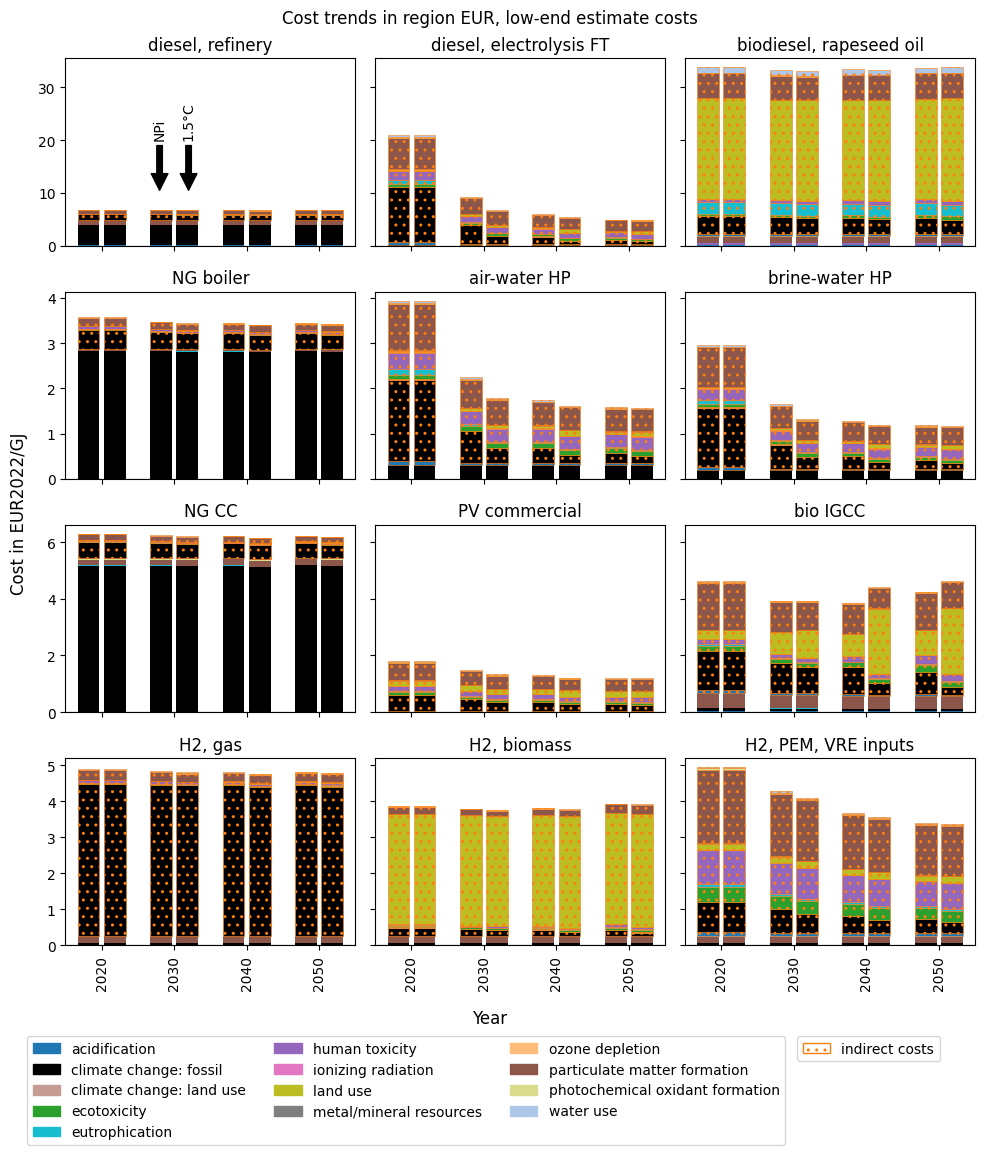

In [41]:
region = "EUR"
perspective = "low estimate"

fig, axs = plt.subplots(4, 3, sharex=True,  sharey="row", figsize=(10, 10.5))

fig.suptitle("Cost trends in region {}, {} costs".format(region, perspective2plotname[perspective]))

for ax, tech, sector in zip(axs.flat, trend_selection_techs_stages2, trend_selection_sector_stages2):
    sel_direct = direct_costs_regional_averages.loc[pd.IndexSlice[
        tech, sector, :, :, region, perspective
    ]] * 1000
    sel_indirect = indirect_costs_regional_averages.loc[pd.IndexSlice[
        tech, sector, :, :, region, perspective
    ]] * 1000
    cost_trends_subplot_stages(sel_direct, sel_indirect, ax, SCENARIOS, no_bio=True, hatch="..")
    ax.set_title(tech2tick[tech])

ax = axs[0][0]
bwidth = 0.3
spacing = 0.1
ax.annotate("NPi", xy=(1-(spacing+bwidth)/2, 10), xytext=(1-(spacing+bwidth)/2, 10+10),
            arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
            )
ax.annotate("1.5°C", xy=(1+(spacing+bwidth)/2, 10), xytext=(1+(spacing+bwidth)/2, 10+10),
            arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
            )


fig.legend(loc="center left", handles=get_impact_category_handles(palette=colors_splitCC_nobio), 
           bbox_to_anchor=(0.03, -0.05), ncols=3)
fig.legend(loc="center left", handles=[mpatches.Patch(facecolor=("white", 0.0), edgecolor="C1", label="indirect costs", hatch="..")],
           bbox_to_anchor=(0.8, -0.01))

fig.supxlabel("Year")
fig.supylabel("Cost in EUR{}/GJ".format(EURO_REF_YEAR))

fig.tight_layout()
fig.savefig(output_fp+"/plots/main/03_trends_stages2_{}_{}.pdf".format(region, perspective), bbox_inches="tight")

### Extended sensitivity analysis plot

In [42]:
sensdata = pd.read_csv(output_fp+"/gsa_ofat_all_sensdata.csv")

plot_data = sensdata.pivot(index=["short name", "sector"], columns="stage", values="sensitivity")
plot_data = plot_data.reset_index()

We filter out the sensitivities for solids.

In [43]:
plot_data = plot_data[plot_data["sector"] != "solids"]
plot_data

stage,short name,sector,biosphere,monetization,technosphere
0,BIGCC,electricity production,0.086982,0.906500,0.006518
1,BIGCC w CCS,electricity production,0.057357,0.933848,0.008795
2,"CSP, tower",electricity production,0.034891,0.804752,0.160357
3,"CSP, trough",electricity production,0.131073,0.614591,0.254336
4,NGCC,electricity production,0.042592,0.861781,0.095627
...,...,...,...,...,...
143,wood CHP modern,electricity production,0.104342,0.856729,0.038928
144,wood heater,residential heating,0.471907,0.524164,0.003929
145,"wood heater, modern",residential heating,0.452445,0.543497,0.004058
147,wood power plant,electricity production,0.438085,0.536054,0.025861


How many of the technologies are in the upper triangle (monetization sensitivity > 80%)?

In [44]:
len(plot_data[plot_data["monetization"] > 0.8]) / len(plot_data)

0.5214285714285715

In [45]:
1 / 25

0.04

In [46]:
distdata = pd.read_csv(output_fp+"/gsa_ofat_all_outputsamples.csv").set_index([
    "short name", "sector", "stage", "sample index"])
distdata

output value  \
short name                     sector                 stage        sample index                 
BIGCC                          electricity production technosphere 0                 0.102113   
                                                                   1                 0.105272   
                                                                   2                 0.102952   
                                                                   3                 0.101132   
                                                                   4                 0.100353   
...                                                                                       ...   
diffusion adsorption heat pump residential heating    biosphere    1995              0.021843   
                                                                   1996              0.025134   
                                                                   1997              0.022911   
                                                                   1998              0.018084   
                                                                   1999              0.020782   

                                                                                 scenario  \
short name                     sector                 stage        sample index             
BIGCC                          electricity production technosphere 0             SSP2-NPi   
                                                                   1             SSP2-NPi   
                                                                   2             SSP2-NPi   
                                                                   3             SSP2-NPi   
                                                                   4             SSP2-NPi   
...                                                                                   ...   
diffusion adsorption heat pump residential heating    biosphere    1995          SSP2-NPi   
                                                                   1996          SSP2-NPi   
                                                                   1997          SSP2-NPi   
                                                                   1998          SSP2-NPi   
                                                                   1999          SSP2-NPi   

                                                                                 year  \
short name                     sector                 stage        sample index         
BIGCC                          electricity production technosphere 0             2030   
                                                                   1             2030   
                                                                   2             2030   
                                                                   3             2030   
                                                                   4             2030   
...                                                                               ...   
diffusion adsorption heat pump residential heating    biosphere    1995          2030   
                                                                   1996          2030   
                                                                   1997          2030   
                                                                   1998          2030   
                                                                   1999          2030   

                                                                                location  
short name                     sector                 stage        sample index           
BIGCC                          electricity production technosphere 0               World  
                                                                   1               World  
                                                                   2               Worl

In [47]:
costs = xr.open_dataarray(output_fp+"/gsa_ofat_all_costs.nc")
nominals = costs.mean(dim="sample index").to_series()

In [48]:
nominals

activity key
('BIGCC', 'electricity production')                          0.112495
('BIGCC w CCS', 'electricity production')                    0.008094
('hard coal IGCC', 'electricity production')                 0.289078
('hard coal w CCS (post)', 'electricity production')         0.311611
('hard coal IGCC w CCS (pre)', 'electricity production')     0.257423
                                                               ...   
('wood heater, modern', 'residential heating')               0.056165
('wood heater', 'residential heating')                       0.074102
('natural gas boiler', 'residential heating')                0.022086
('biomethane boiler', 'residential heating')                 0.014715
('diffusion adsorption heat pump', 'residential heating')    0.020494
Length: 149, dtype: float64

In [49]:
techs_for_distributions = [
    "geothermal",
    "lignite briquette stove",
    "NGCC w CCS (post)",
    "diesel, electrolysis FT, VRE"
]
sectors_for_distributions = [
    "electricity production",
    "residential heating",
    "electricity production",
    "liquids"
]
xlimits = [
    [0, 6],
    [0, 10],
    [0, 3],
    [0, 7]
]

titles = ["monetization", "technosphere", "biosphere"]

Split data in the 4 special techs and the rest

In [50]:
idx_focus = [(tech, sector) for tech, sector in zip(techs_for_distributions, sectors_for_distributions)]
plot_data_focus = plot_data.set_index(["short name", "sector"]).loc[idx_focus].reset_index()
plot_data_rest = plot_data.set_index(["short name", "sector"]).drop(index=idx_focus).reset_index()

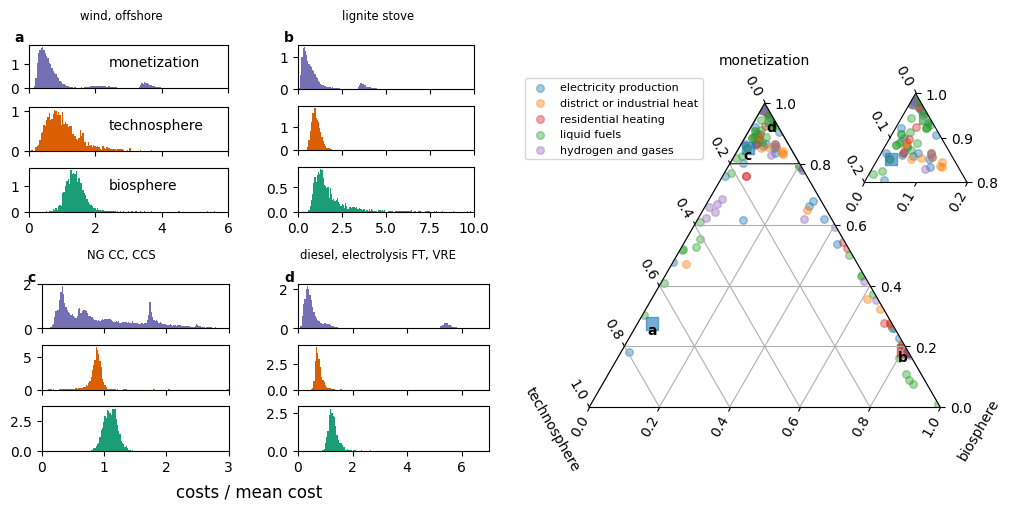

In [51]:
fig = plt.figure(figsize=(10, 5), layout="constrained")

subfigs = fig.subfigures(1, 2)

subfigs_left = subfigs[0].subfigures(2, 2)
ax_right = subfigs[1].add_subplot(111, projection="ternary")

subfigs[0].supxlabel("costs / mean cost")

subplots_labels = list("abcd")

# plot distributions
for i, sfig in enumerate(subfigs_left.flat):
    sfig.get_layout_engine().set(wspace=0.05)
    axs = sfig.subplots(3, 1, sharex=True)
    # plt.subplots_adjust(hspace=0)
    
    tech = techs_for_distributions[i]
    sector = sectors_for_distributions[i]

    idx = str((tech, sector))

    scale = nominals.loc[idx]
    ycosts = costs.sel({"activity key": idx}).to_numpy()
    ybio = distdata.loc[pd.IndexSlice[tech, sector, "biosphere", :]]["output value"].to_numpy()
    ytech = distdata.loc[pd.IndexSlice[tech, sector, "technosphere", :]]["output value"].to_numpy()

    data = [ycosts/scale, ytech/scale, ybio/scale]
    
    bins = np.linspace(xlimits[i][0], xlimits[i][1], 150)

    for j, ax in enumerate(axs):
        ax.hist(data[j], bins=bins, density=True, color=stage2color[titles[j]])
        ax.set_xlim(xlimits[i])
        if i == 0:
            ax.text(0.4, 0.5, titles[j], transform=ax.transAxes)

    sfig.suptitle(tech2tick[tech], fontsize="small")

    # put a label
    axs[0].annotate(
        subplots_labels[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(-1, +1), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontweight='bold',
    )


# ax = plt.subplot(projection="ternary")
ax_right.grid()
ax_right.set_tlabel("monetization")
ax_right.set_llabel("technosphere")
ax_right.set_rlabel("biosphere")

for sector, c in sector2color.items():
    sel = plot_data_rest[plot_data_rest["sector"] == sector]
    ax_right.scatter(sel["monetization"], sel["technosphere"], sel["biosphere"],
                     label=sector2plotname[sector], alpha=0.4, color=c, s=30)

ax_right.scatter(plot_data_focus["monetization"],
                 plot_data_focus["technosphere"],
                 plot_data_focus["biosphere"],
                 alpha=0.6, c=[sector2color[s] for s in sectors_for_distributions], s=80, marker="s")

plot_labels(ax_right, plot_data_focus, ["monetization", "technosphere", "biosphere"],
            ha="center", va="top", fontweight="bold")
    
ax_right.legend(loc="upper left", bbox_to_anchor=(-0.2, 1.1), fontsize=8)

# Plot the triangle region for the inset.
ax_right.fill([1.0, 0.8, 0.8], [0.0, 0.2, 0.0], [0.0, 0.0, 0.2], fc="none", ec="k")

# Create a new `TernaryAxes` for the inset with specifying a rectangle in the
# figure coordinates.
ax_inset = subfigs[1].add_axes([0.71, 0.63, 0.21, 0.21], projection="ternary")

# Limit the ploting range to be consistent with the above plotted triangle.
ax_inset.set_ternary_lim(
    0.8, 1.0,
    0.0, 0.2,
    0.0, 0.2
)

for sector, c in sector2color.items():
    sel = plot_data_rest[plot_data_rest["sector"] == sector]
    ax_inset.scatter(sel["monetization"], sel["technosphere"], sel["biosphere"],
                     alpha=0.4, color=c, s=30)
    
ax_inset.scatter(plot_data_focus["monetization"],
                 plot_data_focus["technosphere"],
                 plot_data_focus["biosphere"],
                 alpha=0.6, c=[sector2color[s] for s in sectors_for_distributions], s=80, marker="s")

ax_inset.taxis.set_ticks([0.8, 0.9, 1.0])
ax_inset.laxis.set_ticks([0.0, 0.1, 0.2])
ax_inset.raxis.set_ticks([0.0, 0.1, 0.2])

fig.savefig(output_fp+"/plots/main/04_SA.pdf")